In [1]:
import os
import time
import logging
import yaml
import ast
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from pprgo import utils
from pprgo import ppr
from pprgo import pprgo

In [2]:
# Set up logging
logger = logging.getLogger()
logger.handlers = []
ch = logging.StreamHandler()
formatter = logging.Formatter(
        fmt='%(asctime)s (%(levelname)s): %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.setLevel('INFO')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Load config

In [3]:
with open('config_demo.yaml', 'r') as c:
    config = yaml.safe_load(c)

In [4]:
# For strings that yaml doesn't parse (e.g. None)
for key, val in config.items():
    if type(val) is str:
        try:
            config[key] = ast.literal_eval(val)
        except (ValueError, SyntaxError):
            pass

In [5]:
data_file           = config['data_file']           # Path to the .npz data file
data_file = 'data/cora_full.npz'
split_seed          = config['split_seed']          # Seed for splitting the dataset into train/val/test
ntrain_div_classes  = config['ntrain_div_classes']  # Number of training nodes divided by number of classes
attr_normalization  = config['attr_normalization']  # Attribute normalization. Not used in the paper

alpha               = config['alpha']               # PPR teleport probability
alpha = 0.25
eps                 = config['eps']                 # Stopping threshold for ACL's ApproximatePR
topk                = config['topk']                # Number of PPR neighbors for each node
ppr_normalization   = config['ppr_normalization']   # Adjacency matrix normalization for weighting neighbors

hidden_size         = config['hidden_size']         # Size of the MLP's hidden layer
nlayers             = config['nlayers']             # Number of MLP layers
weight_decay        = config['weight_decay']        # Weight decay used for training the MLP
dropout             = config['dropout']             # Dropout used for training

lr                  = config['lr']                  # Learning rate
max_epochs          = config['max_epochs']          # Maximum number of epochs (exact number if no early stopping)
batch_size          = config['batch_size']          # Batch size for training
batch_mult_val      = config['batch_mult_val']      # Multiplier for validation batch size

eval_step           = config['eval_step']           # Accuracy is evaluated after every this number of steps
run_val             = config['run_val']             # Evaluate accuracy on validation set during training

early_stop          = config['early_stop']          # Use early stopping
patience            = config['patience']            # Patience for early stopping

nprop_inference     = config['nprop_inference']     # Number of propagation steps during inference
inf_fraction        = config['inf_fraction']        # Fraction of nodes for which local predictions are computed during inference

In [6]:
def pprgo_algorithm():

    print('k: ', topk)

    #LOAD THE DATA------------------------------------
    start = time.time()
    (adj_matrix, attr_matrix, labels,
    train_idx, val_idx, test_idx) = utils.get_data(
            f"{data_file}",
            seed=split_seed,
            ntrain_div_classes=ntrain_div_classes,
            normalize_attr=attr_normalization
    )

    # print(adj_matrix.toarray().shape)
    
    
    try:
        d = attr_matrix.n_columns
    except AttributeError:
        d = attr_matrix.shape[1]
    nc = labels.max() + 1
    time_loading = time.time() - start
    # print(f"Loading data Runtime: {time_loading:.2f}s")


    #PREPROCESSING: CALCULATE PPR SCORES----------------

    # compute the ppr vectors for train/val nodes using ACL's ApproximatePR
    start = time.time()
    topk_train = ppr.topk_ppr_matrix(adj_matrix, alpha, eps, train_idx, topk,
                                    normalization=ppr_normalization)
    if run_val:
        topk_val = ppr.topk_ppr_matrix(adj_matrix, alpha, eps, val_idx, topk,
                                    normalization=ppr_normalization)
    else:
        topk_val = None
    time_preprocessing = time.time() - start
    # print(f"PPR scores Runtime: {time_preprocessing:.2f}s")

    #TRAINING: SET UP MODEL AND TRAIN
    start = time.time()
    tf.reset_default_graph()
    tf.set_random_seed(0)

    model = pprgo.PPRGo(d, nc, hidden_size, nlayers, lr, weight_decay, dropout,
                        sparse_features=type(attr_matrix) is not np.ndarray)

    sess = tf.compat.v1.Session()
    with sess.as_default():
        tf.compat.v1.global_variables_initializer().run()
        nepochs, loss_hist, acc_hist, f1_hist = pprgo.train(
                sess=sess, model=model, attr_matrix=attr_matrix,
                train_idx=train_idx, val_idx=val_idx,
                topk_train=topk_train, topk_val=topk_val,
                labels=labels,
                max_epochs=max_epochs, batch_size=batch_size, batch_mult_val=batch_mult_val,
                eval_step=eval_step, early_stop=early_stop, patience=patience)
    time_training = time.time() - start
    logging.info('Training done.')
    # print(f"Training Runtime: {time_training:.2f}s")

    #INFERENCE (VAL AND TEST)
    start = time.time()
    predictions, time_logits, time_propagation = model.predict(
            sess=sess, adj_matrix=adj_matrix, attr_matrix=attr_matrix, alpha=alpha,
            nprop=nprop_inference, inf_fraction=inf_fraction,
            ppr_normalization=ppr_normalization)
    time_inference = time.time() - start
    # print(f"Inference Runtime: {time_inference:.2f}s")


    #COLLECT AND PRINT RESULTS
    acc_train = 100 * accuracy_score(labels[train_idx], predictions[train_idx])
    acc_val = 100 * accuracy_score(labels[val_idx], predictions[val_idx])
    acc_test = 100 * accuracy_score(labels[test_idx], predictions[test_idx])
    f1_train = f1_score(labels[train_idx], predictions[train_idx], average='macro')
    f1_val = f1_score(labels[val_idx], predictions[val_idx], average='macro')
    f1_test = f1_score(labels[test_idx], predictions[test_idx], average='macro')

    # gpu_max_bytes = tf.contrib.memory_stats.MaxBytesInUse()
    # gpu_memory = sess.run(gpu_max_bytes)
    memory = utils.get_max_memory_bytes()

    time_total = time_preprocessing + time_training + time_inference

    print(f'''
    Accuracy: Train: {acc_train:.1f}%, val: {acc_val:.1f}%, test: {acc_test:.1f}%
    F1 score: Train: {f1_train:.3f}, val: {f1_val:.3f}, test: {f1_test:.3f}

    Runtime: Preprocessing: {time_preprocessing:.2f}s, training: {time_training:.2f}s, inference: {time_inference:.2f}s -> total: {time_total:.2f}s
    Memory: Main: {(memory/1024) / 2**30:.2f}GB
    ''')

    return acc_test, time_total, ((memory/1024) / 2**30)



In [7]:
logger = logging.getLogger()
logger.disabled = True

k_values = []
iterations = 1

ACCURACY_RESUTS= []
TIME_RESULTS = []
MEMORY = []
GPU_MEMORY = []


elapsed_time = 0
topk = 16

while elapsed_time < 78.549:

    if topk >= 256:
        break

    topk *= 2
    
    all_acc = []
    all_times = []
    main_memory_list = []
    
    for i in range(iterations):
        acc_test_, time_total_, memory_ = pprgo_algorithm()
    
        all_acc.append(acc_test_)
        all_times.append(time_total_)
        main_memory_list.append(memory_)
    
    #Calculate mean 
    k_values.append(topk)
    ACCURACY_RESUTS.append(sum(all_acc)/len(all_acc))
    TIME_RESULTS.append(sum(all_times)/len(all_times))
    MEMORY.append(sum(main_memory_list)/len(main_memory_list))


    elapsed_time = sum(all_times)/len(all_times)
    print('ELAPSED TIME: ', elapsed_time)





k:  32



2022-05-25 18:24:46 (WARNING): From /var/folders/x5/bhlqr68144x_138bllx2mdwh0000gn/T/ipykernel_85711/3345303984.py:43: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.



2022-05-25 18:24:46 (WARNING): From /var/folders/x5/bhlqr68144x_138bllx2mdwh0000gn/T/ipykernel_85711/3345303984.py:44: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.




    Accuracy: Train: 70.5%, val: 50.2%, test: 49.2%
    F1 score: Train: 0.591, val: 0.334, test: 0.322

    Runtime: Preprocessing: 8.70s, training: 21.79s, inference: 0.11s -> total: 30.60s
    Memory: Main: 0.50GB
    
ELAPSED TIME:  30.596395254135132
k:  64

    Accuracy: Train: 80.9%, val: 55.5%, test: 54.7%
    F1 score: Train: 0.723, val: 0.405, test: 0.391

    Runtime: Preprocessing: 0.58s, training: 33.63s, inference: 0.10s -> total: 34.31s
    Memory: Main: 0.56GB
    
ELAPSED TIME:  34.31300711631775
k:  128


KeyboardInterrupt: 

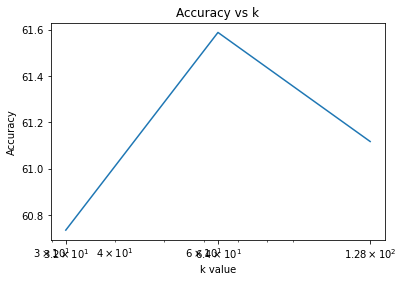

In [ ]:
import matplotlib.pyplot as plt

# k_values = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
# print(ACCURACY_RESUTS)
# print(TIME_RESULTS)
  
# plotting the points 
plt.plot(k_values, ACCURACY_RESUTS)
  
# naming the x axis
plt.xlabel('k value')
plt.xscale('log')
plt.xticks(k_values)


# naming the y axis
plt.ylabel('Accuracy')
  
# giving a title to my graph
plt.title('Accuracy vs k')
  
# function to show the plot
plt.show()

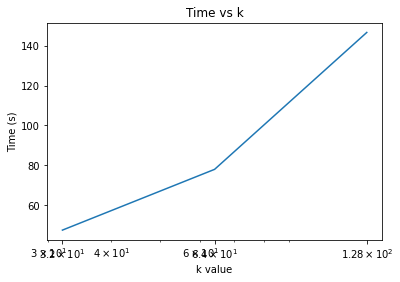

In [ ]:
plt.plot(k_values, TIME_RESULTS)
plt.xlabel('k value')
plt.xscale('log')
plt.xticks(k_values)

plt.ylabel('Time (s)')
  
# giving a title to my graph
plt.title('Time vs k')
  
# function to show the plot
plt.show()

In [ ]:
from tabulate import tabulate

table = []
#Build table
table.append(['k', 'Accuracy', 'Running time (s)', 'Main Memory (GB)', 'GPU Memory(GB)'])
for i in range(len(k_values)):
    current_row = []
    current_row.append(k_values[i])
    current_row.append(ACCURACY_RESUTS[i])
    current_row.append(TIME_RESULTS[i])
    current_row.append(MEMORY[i])
    table.append(current_row)

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═════╤════════════╤════════════════════╤════════════════════╕
│   k │   Accuracy │   Running time (s) │   Main Memory (GB) │
╞═════╪════════════╪════════════════════╪════════════════════╡
│  32 │    60.7353 │            47.4761 │           0.491009 │
├─────┼────────────┼────────────────────┼────────────────────┤
│  64 │    61.5882 │            77.9657 │           0.559036 │
├─────┼────────────┼────────────────────┼────────────────────┤
│ 128 │    61.1176 │           146.65   │           0.711979 │
╘═════╧════════════╧════════════════════╧════════════════════╛


# Load the data

# Preprocessing: Calculate PPR scores

# Training: Set up model and train

# Inference (val and test)

# Collect and print results